# 1. Setup

#  1.1 Install dependencies

In [1]:
# Downloads and installs the dependencies
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib 

# 1.2 Import tensorflow layers

# 1.2.1 Import standard dependencies

In [2]:
import cv2 # for image and video analysis
import os # for creating and accessing folders
import random
import numpy as np 
from matplotlib import pyplot as plt

# 1.2.2 Import tensorflow dependencies

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# 1.3 Setup Growth

In [4]:
#Avoiding out of memory errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
len(gpus)

0

# 1.4 Create Data folders

In [6]:
#setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
POS_PATH

'data\\positive'

In [8]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors 

# 2.1 Untar labelled faces in the wild dataset

In [9]:
# https://vis-www.cs.umass.edu/lfw/#download

In [10]:
# uncompress Tar GZ laballed faces in the  wild dataset(lfw)
!tar -xf lfw.tgz  

In [11]:
#move lfw images to the following repository: data//negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# 2.2 Collect Positive and Anchor Images

In [12]:
# Import uuid library to generate unique image names
import uuid

In [13]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\5ef881f4-ac48-11f0-a4d7-e4b318b8a3a7.jpg'

In [14]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Resize/cut down  the frame to 250 x 250 px
    frame = frame[150:150+250, 200:200+250, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
        
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out positive image
        cv2.imwrite(imgname, frame)
        
    # Collect more negatives
    if cv2.waitKey(1) & 0XFF == ord('n'):
        #create unique file path
        imgname = os.path.join(NEG_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out positive image
        cv2.imwrite(imgname, frame)
    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

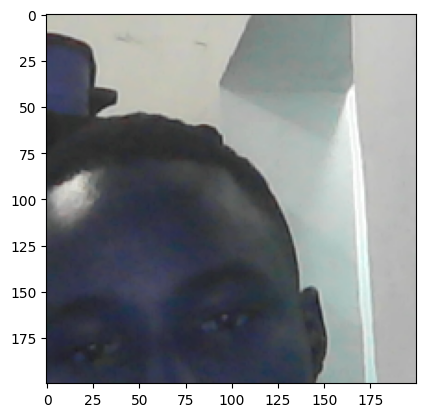

In [15]:
plt.imshow(frame[50:50+250, 50:50+250, :]) 

# 3. Load and preprocess images

# 

# 3.1 Get Image Directories

In [16]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(2407)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(820)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(2000)

In [17]:
dir_test = anchor.as_numpy_iterator()

In [18]:
dir_test.next()

b'data\\anchor\\c159fc6e-4c19-11ee-88bd-3464a906fd38.jpg'

# 3.2 Preprocessing - Scale and Resize

In [19]:
def preprocess(file_path): 
    # read in image from file path
    byte_img = tf.io.read_file(file_path)
    
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    # Return image
    return img

In [20]:
img =  preprocess('data\\anchor\\c159fc6e-4c19-11ee-88bd-3464a906fd38.jpg')

In [21]:
img.numpy().min()

0.089705884

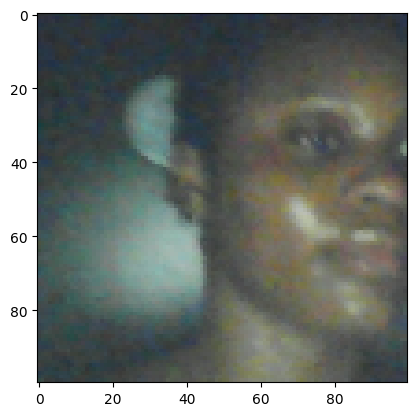

In [22]:
plt.imshow(img)

# 3.3 Create Labelled Dataset

In [23]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0


In [24]:
#class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [25]:
#iterator_labs = class_labels.as_numpy_iterator()

In [26]:
#iterator_labs.next()

In [27]:
#tf.ones(len(anchor))

In [28]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) #zip allows us to iterate through all three 
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [29]:
samples = data.as_numpy_iterator()

In [30]:
example = samples.next()

In [31]:
example

(b'data\\anchor\\3ce60e10-4720-11ee-85d9-3464a906fd38.jpg',
 b'data\\positive\\5eb7765c-4c19-11ee-bd69-3464a906fd38.jpg',
 1.0)

In [32]:
#data

# 3.4 Build Train and Test Partition

In [33]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [34]:
res = preprocess_twin(*example)

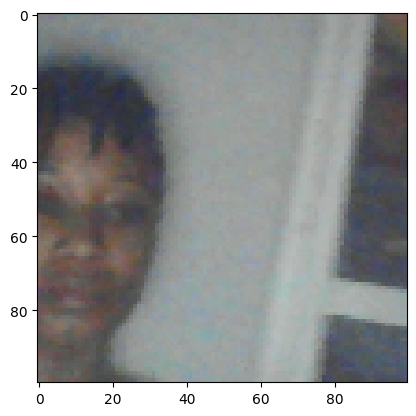

In [35]:
plt.imshow(res[1])

In [36]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

# 

In [37]:
samples = data.as_numpy_iterator()

In [38]:
samples.next()

(array([[[0.31593138, 0.3120098 , 0.30416667],
         [0.41887254, 0.42892158, 0.41642156],
         [0.51053923, 0.5272059 , 0.52181375],
         ...,
         [0.8593137 , 0.86715686, 0.8632353 ],
         [0.85784316, 0.8656863 , 0.8617647 ],
         [0.8617647 , 0.86960787, 0.8656863 ]],
 
        [[0.32254902, 0.31862745, 0.3019608 ],
         [0.45563725, 0.46348038, 0.44534314],
         [0.54068625, 0.55514705, 0.54656863],
         ...,
         [0.8617647 , 0.86960787, 0.8656863 ],
         [0.85588235, 0.8637255 , 0.8598039 ],
         [0.85588235, 0.8637255 , 0.8598039 ]],
 
        [[0.3732843 , 0.37009802, 0.34240195],
         [0.49411765, 0.49803922, 0.4762255 ],
         [0.54019606, 0.54509807, 0.5269608 ],
         ...,
         [0.85882354, 0.8666667 , 0.8627451 ],
         [0.8595588 , 0.86740196, 0.8634804 ],
         [0.8571078 , 0.86495095, 0.8610294 ]],
 
        ...,
 
        [[0.9764706 , 0.9843137 , 0.98039216],
         [0.97843134, 0.9862745 , 0.98235

# 

In [39]:
len(samples.next())

3

In [40]:
samples.next()[0]

array([[[0.62009805, 0.64362746, 0.59460783],
        [0.64387256, 0.66593134, 0.6276961 ],
        [0.65392154, 0.66568625, 0.63480395],
        ...,
        [0.67745095, 0.6401961 , 0.54558825],
        [0.672549  , 0.64411765, 0.5720588 ],
        [0.6666667 , 0.64705884, 0.57254905]],

       [[0.6365196 , 0.66789216, 0.6227941 ],
        [0.64485294, 0.67107844, 0.64681375],
        [0.6514706 , 0.6696078 , 0.6664216 ],
        ...,
        [0.67034316, 0.6392157 , 0.5529412 ],
        [0.6696078 , 0.64215684, 0.57230395],
        [0.66593134, 0.6453431 , 0.5737745 ]],

       [[0.6647059 , 0.6931372 , 0.6313726 ],
        [0.6620098 , 0.68602943, 0.6490196 ],
        [0.6671569 , 0.68014705, 0.6632353 ],
        ...,
        [0.66740197, 0.6370098 , 0.5566176 ],
        [0.66813725, 0.64142156, 0.5715686 ],
        [0.66568625, 0.6394608 , 0.56936276]],

       ...,

       [[0.74460787, 0.8262255 , 0.9014706 ],
        [0.75465685, 0.84289217, 0.9139706 ],
        [0.76985294, 0

In [41]:
samp = samples.next()

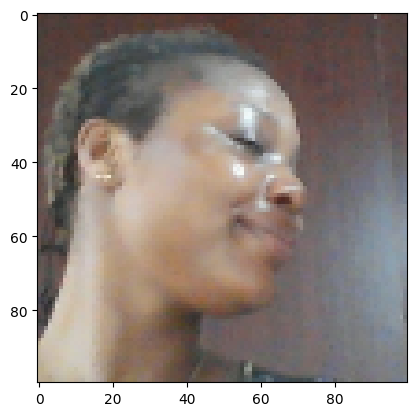

In [42]:
plt.imshow(samp[0])

# 

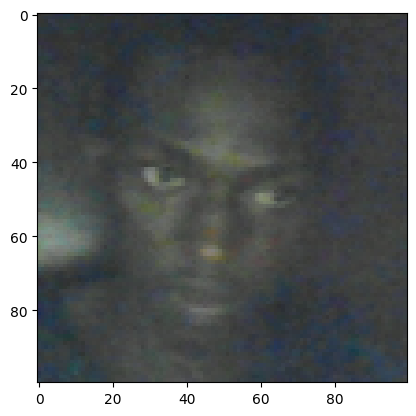

In [43]:
plt.imshow(samp[1])

In [44]:
samp[2]

1.0

In [45]:
round(len(data)*.7)

1974

In [46]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [47]:
#Training partition 
train_data = data.take(round(len(data)*.7))

# Pass through data as  batch of 16 images
train_data = train_data.batch(20)

# Starts preprocessing the next set
train_data = train_data.prefetch(10) 

In [48]:
train_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [49]:
train_samples  =  train_data.as_numpy_iterator()

In [50]:
train_sample = train_samples.next()

In [51]:
len(train_sample[0])

20

# 

In [52]:
# testing partition 
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(20)
test_data = test_data.prefetch(10)

# 4. Model Engineering

# 4.1 Building Embedding Layer

In [53]:
inp = Input(shape=(100,100,3), name='input_image')

In [54]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [55]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [56]:
m1 = MaxPooling2D(64, (2,2), padding="same")(c1)

In [57]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [58]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding="same")(c2)

In [59]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding="same")(c3) 

In [60]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [61]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [62]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [63]:
mod = Model(inputs=[inp], outputs=[d1], name ='embedding' )

In [64]:
mod

In [65]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [66]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding="same")(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding="same")(c2)
    
    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding="same")(c3) 
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name ='embedding' ) 

In [67]:
embedding = make_embedding()

In [68]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

# 4.2 Build Distance Layer

In [69]:
# Siamese L1 Distance Class

class L1Dist(Layer):
    # the self argument is to allow us to operate on ourselves, and 
    # **kwargs allows to work with the specific layer as part of a bigger model
    # Init methd for inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # magic happens here i.e similarity calculations
    # the call function tells the layer what to do when some data is passed to it
    # the tf.math.abs returns an absolute value
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [70]:
l1 = L1Dist

# 4.3 Make Siamese Model

In [71]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [72]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [73]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [74]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [75]:
siamese_layer = L1Dist()

In [76]:
distances = siamese_layer(inp_embedding, val_embedding)

In [77]:
classifier = Dense(1, activation='sigmoid')(distances)

In [78]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [79]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [80]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist (L1Dist)                (None, 4096)         0           embedding[0][0]     

In [81]:
  def make_siamese_model():
        
        # anchor image input in the network
        input_image = Input(name='input_img', shape=(100,100,3))
        
        # validation image in the network
        validation_image = Input(name='validation_img', shape=(100,100,3))
        
        # combine siamese distance components 
        siamese_layer = L1Dist()
        siamese_layer._name = 'distance'
        distances = siamese_layer(embedding(input_image), embedding(validation_image))
        
        # classification layer
        classifier = Dense(1, activation='sigmoid')(distances)
        
        return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
        

In [82]:
siamese_model = make_siamese_model()

In [83]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training a Siamese Neural Network

# 5.1 Setup Loss and Optimizer

In [84]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [85]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

# 5.2 Establish Checkpoints

In [86]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# 5.3 Build Train Step Funtion

In [87]:
test_batch = train_data.as_numpy_iterator()

In [88]:
batch_1 = test_batch.next()

In [89]:
x = batch_1[:2]

In [90]:
len(x)

2

In [98]:
y = batch_1[2]

In [99]:
y

array([0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
       1., 1., 1.], dtype=float32)

In [100]:
# wrapping the function inside the @tf.function, 
# compiles the funtion into a poolable tensorflow graph
@tf.function

# defines our function, the batch positional argument passes in the batch of data
def train_step(batch):
     
    #this allows us to start capturing our gradient from the neural model, 
    # performing differentiation for backpropagation 
    #  by recording everything single thing happened in the neural network
    with tf.GradientTape() as tape:
        # get anchor and positive/negative image
        x = batch[:2]
        # Get label
        y = batch[2]
        
        # forward pass
        yhat = siamese_model(x, training=True)
        # calculate loss
        loss = binary_cross_loss(y, yhat)  
    print(loss)
        
    # calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # return loss
    return loss

# 5.4 Build Training Loop

In [101]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))  
        progbar = tf.keras.utils.Progbar(len(data))
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


# 5.5 Train the model

In [102]:
EPOCHS = 25

In [103]:
train(train_data, EPOCHS)
#predict = cnn.fit(training_set, epochs = 50, validation_data=testing_set)


 Epoch 1/25
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
99/99 [==============================] - 4832s 48s/step

 Epoch 2/25
99/99 [==============================] - 10981s 111s/step

 Epoch 3/25
99/99 [==============================] - 4200s 42s/step

 Epoch 4/25
99/99 [==============================] - 3784s 38s/step

 Epoch 5/25
99/99 [==============================] - 3750s 38s/step

 Epoch 6/25
99/99 [==============================] - 3730s 38s/step

 Epoch 7/25
99/99 [==============================] - 3801s 38s/step

 Epoch 8/25
99/99 [==============================] - 3758s 38s/step

 Epoch 9/25
99/99 [==============================] - 3780s 38s/step

 Epoch 10/25
99/99 [==============================] - 3736s 38s/step

 Epoch 11/25
99/99 [==============================] - 3743s 38s/step

 Epoch 12/25
99/99 [==============================] - 3879s 39s/step

 Epoch 13/25
99/99 [==============================] - 5220s 53s/step

 Epoch 14/25
99/99 

# 6. Evaluate Model

## 6.1 Import Metrics

In [104]:
#import metric calculation, there's a variety of these metrics for tf
from tensorflow.keras.metrics import Precision, Recall 

## 6.2 Make Predictions

In [105]:
#Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next() 
# This is going to convert the data into a numpy equivalent

In [106]:
#make predictions
y_hat = siamese_model.predict([test_input, test_val])

In [107]:
y_hat

array([[9.9012828e-01],
       [9.0125811e-01],
       [2.4259812e-06],
       [2.2895636e-08],
       [5.8598292e-01],
       [6.7546027e-09],
       [1.1310968e-06],
       [1.8621523e-07],
       [9.6755593e-07],
       [1.5049100e-08],
       [5.4046691e-08],
       [4.1320920e-04],
       [9.8871344e-05],
       [2.8678056e-07],
       [6.8953642e-07],
       [1.8179417e-04],
       [5.2914023e-04],
       [1.1932417e-06],
       [4.3284893e-04],
       [5.2731932e-05]], dtype=float32)

In [108]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [109]:
y_true

array([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [110]:
res = []
for prediction in y_hat:
    if prediction > 0.5: 
        res.append(1)
    else:
        res.append(0)

## 6.3 Calculating metrics

In [111]:
#creating a metric object
m = Recall()

#calculating the Recall value
m.update_state(y_true, y_hat)

#return Recall result
m.result().numpy()

1.0

In [112]:
#creating a metric object
m = Precision()

#calculating the Recall value
m.update_state(y_true, y_hat)

#return Recall result
m.result().numpy()

1.0

## 6.4 Visualize Results

<function matplotlib.pyplot.show(close=None, block=None)>

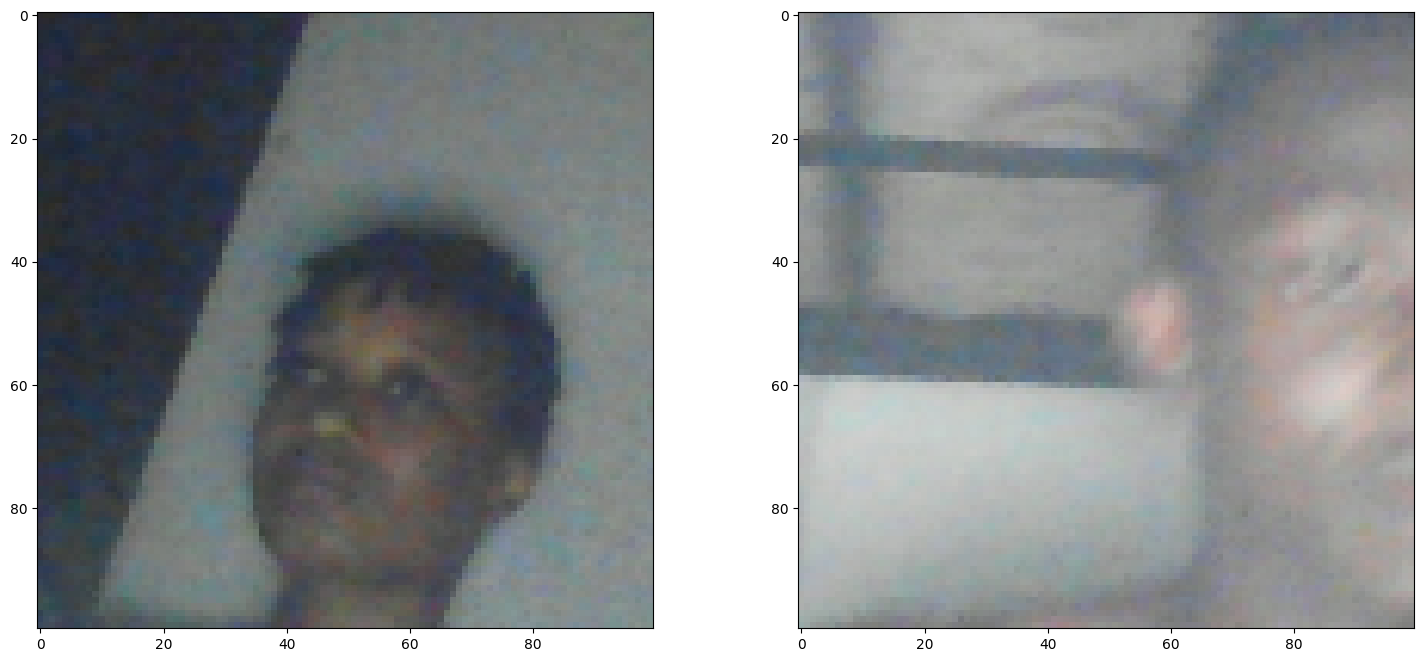

In [113]:
#Set plot size
plt.figure(figsize=(18,8)) #the tuple (18,8) controls how big the plot is

# Set first subplot
plt.subplot(1,2,1) 
# Determines the image that's being plot
plt.imshow(test_input[4])

# Set second plot
plt.subplot(1,2,2)
# Determines the image that's being plot
plt.imshow(test_val[4])

plt.show

# 7. Save Model

In [114]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [115]:
#reload model
model = tf.keras.models.load_model('siamesemodel.h5', \
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [116]:
tf.keras.models.load_model??

In [117]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[9.9012828e-01],
       [9.0125811e-01],
       [2.4259812e-06],
       [2.2895636e-08],
       [5.8598292e-01],
       [6.7546027e-09],
       [1.1310968e-06],
       [1.8621523e-07],
       [9.6755593e-07],
       [1.5049100e-08],
       [5.4046691e-08],
       [4.1320920e-04],
       [9.8871344e-05],
       [2.8678056e-07],
       [6.8953642e-07],
       [1.8179417e-04],
       [5.2914023e-04],
       [1.1932417e-06],
       [4.3284893e-04],
       [5.2731932e-05]], dtype=float32)

In [118]:
# View Model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time predictions/test

## 8.1 Verification Function

In [119]:
os.listdir(os.path.join('application_data', 'verification_images'))

[]

In [120]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [121]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [122]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [124]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.4, 0.4)
        status = print(verified)
        #status = verified
        
        #if status == True:
         #   print("Authorized personnel")
        #if status == False:
         #   print("Intruder detected")
        
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False


# 9. Visualizing my Metrics

In [125]:
!pip install -U scikit-learn


In [126]:
!pip install seaborn

In [127]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

In [128]:
y_pred = model.predict([test_input, test_val])
y_pred_binary = [1 if prediction > 0.5 else 0 for prediction in y_pred]

In [129]:
#Calculating metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
roc_auc = roc_auc_score(y_true, y_pred)
avg_precision = average_precision_score(y_true, y_pred)

## ROC curve

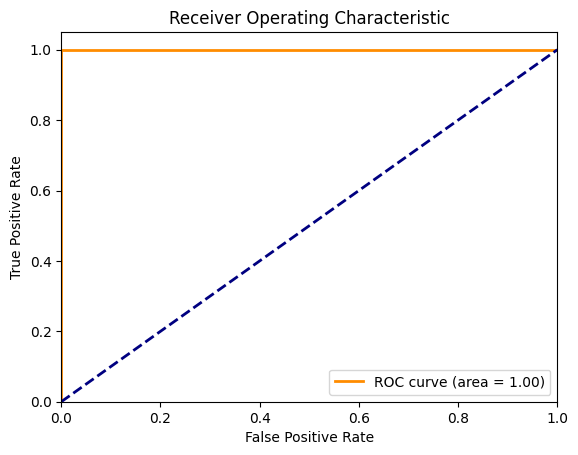

In [130]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Precision-Recall Curve

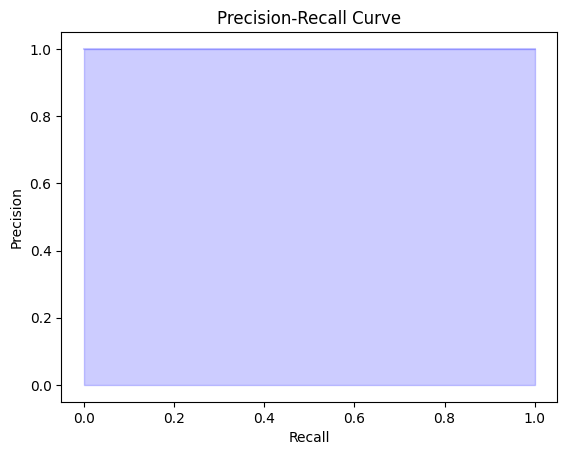

In [131]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


## Metrics

In [132]:
# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC:", roc_auc)
print("Average Precision:", avg_precision)

Accuracy: 1.0
Precision: [1. 1. 1. 1.]
Recall: [1.         0.66666667 0.33333333 0.        ]
F1-Score: 1.0
ROC AUC: 1.0
Average Precision: 1.0


## Confusion Matrix

In [133]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [134]:
# Assuming y_true contains ground truth labels and y_pred contains model predictions
y_pred = model.predict([test_input, test_val])
y_pred_binary = [1 if prediction > 0.5 else 0 for prediction in y_pred]

In [135]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)


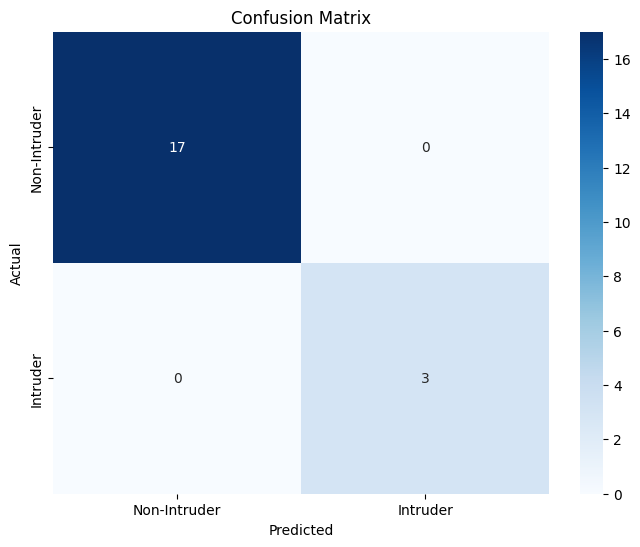

In [136]:
# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Intruder', 'Intruder'],
            yticklabels=['Non-Intruder', 'Intruder'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualizing my convolution neural network architecture

In [137]:
from tensorflow.keras.utils import plot_model

In [138]:
!pip install pydot

In [139]:
!pip install pydotplus

In [140]:
import pydot

In [141]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


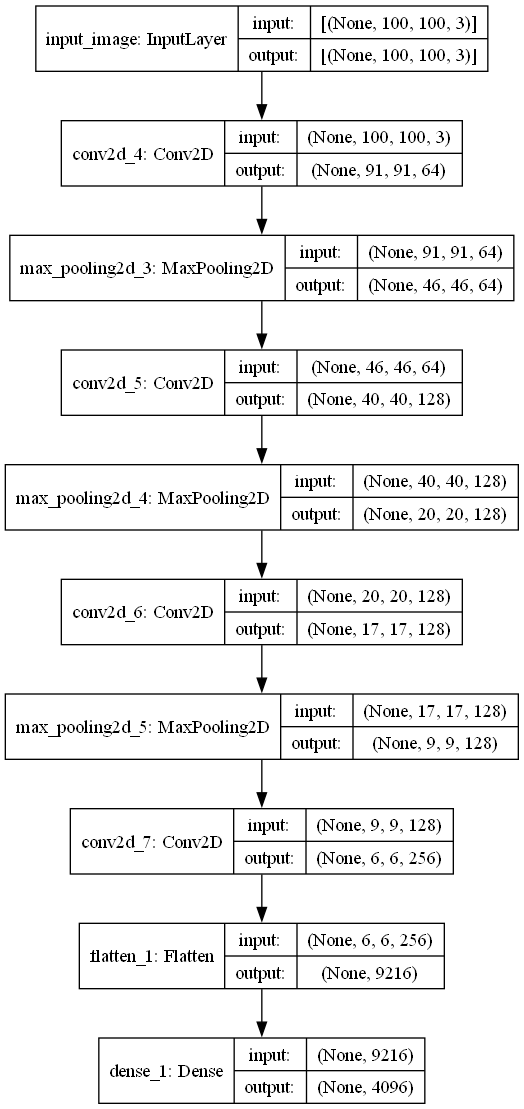

In [142]:
# Visualize the architecture of the embedding model
plot_model(embedding, to_file='embedding_model.png', show_shapes=True, show_layer_names=True)

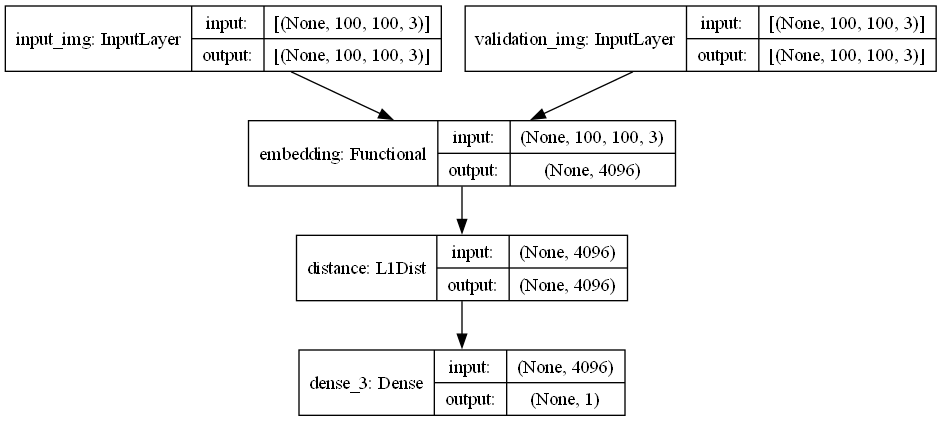

In [143]:
# Visualize the architecture of the siamese model
plot_model(siamese_model, to_file='siamese_model.png', show_shapes=True, show_layer_names=True)